# Imports and Data Preparation

In [240]:
import os
import pandas as pd

import statistics
import networkx as nx
import matplotlib.pyplot as plt

In [241]:
file_names = [x for x in os.listdir("../data") if x.endswith("processed.csv")]
file_names

['19DEC2023_AMS_processed.csv',
 '19DEC2023_HKG_processed.csv',
 '19DEC2023_LHR_processed.csv',
 '20DEC2023_HKG_processed.csv',
 '21DEC2023_AMS_processed.csv',
 '21DEC2023_HKG_processed.csv',
 '22DEC2023_AMS_processed.csv',
 '22DEC2023_HKG_processed.csv']

In [242]:
df = pd.DataFrame()
for file in file_names:
    tmp = pd.read_csv(f"../data/{file}")
    print(file)
    # parse dates
    try:
        tmp.time_sch = pd.to_datetime(tmp.time_sch)
        tmp.time_act = pd.to_datetime(tmp.time_act)
        tmp['source'] = file # just to check

        df = pd.concat([df, tmp], ignore_index=True)

    except Exception as e:
        print(e)
        continue

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

19DEC2023_AMS_processed.csv
19DEC2023_HKG_processed.csv
19DEC2023_LHR_processed.csv
20DEC2023_HKG_processed.csv
21DEC2023_AMS_processed.csv
21DEC2023_HKG_processed.csv
22DEC2023_AMS_processed.csv
22DEC2023_HKG_processed.csv


C:\Users\Javier Alfaro\AppData\Local\Temp\ipykernel_24924\2949998506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp.time_act = pd.to_datetime(tmp.time_act)


In [243]:
df

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff,source,commercial,url
0,2023-12-19 00:00:00,2023-12-19 00:00:00,HV 5752 Transavia,Amsterdam,BAGGAGE HANDLED,Marrakech (RAK),326,0.0,19DEC2023_AMS_processed.csv,NaN,NaN
1,2023-12-19 00:10:00,2023-12-19 00:10:00,HV 6888 Transavia,Amsterdam,BAGGAGE HANDLED,Reykjavik (KEF),262,0.0,19DEC2023_AMS_processed.csv,NaN,NaN
2,2023-12-19 00:15:00,2023-12-19 00:15:00,HV 6110 Transavia,Amsterdam,BAGGAGE HANDLED,Malaga (AGP),233,0.0,19DEC2023_AMS_processed.csv,NaN,NaN
3,2023-12-19 00:20:00,2023-12-19 00:44:00,OR 3721 TUI fly,Amsterdam,BAGGAGE HANDLED,Sao Vicente Island (VXE),227,1440.0,19DEC2023_AMS_processed.csv,NaN,NaN
4,2023-12-19 00:25:00,2023-12-19 00:25:00,HV 5662 Transavia,Amsterdam,BAGGAGE HANDLED,Las Palmas de Gran Canaria (LPA),310,0.0,19DEC2023_AMS_processed.csv,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8776,2023-12-22 23:50:00,2023-12-23 00:22:00,HX 761,Bangkok,NaN,HKG,412,NaN,22DEC2023_HKG_processed.csv,1.0,NaN
8777,2023-12-22 23:55:00,2023-12-23 00:05:00,CX 101,Sydney,NaN,HKG,285,NaN,22DEC2023_HKG_processed.csv,1.0,NaN
8778,2023-12-22 23:55:00,2023-12-23 00:36:00,UO 689,HKG,NaN,Osaka/Kansai,393,NaN,22DEC2023_HKG_processed.csv,1.0,NaN
8779,2023-12-22 23:55:00,2023-12-22 23:57:00,UO 624,Tokyo/HND,NaN,HKG,278,NaN,22DEC2023_HKG_processed.csv,1.0,NaN


In [244]:
df.source.value_counts()

source
22DEC2023_AMS_processed.csv    1281
19DEC2023_LHR_processed.csv    1275
21DEC2023_AMS_processed.csv    1200
19DEC2023_AMS_processed.csv    1147
22DEC2023_HKG_processed.csv     990
21DEC2023_HKG_processed.csv     968
20DEC2023_HKG_processed.csv     966
19DEC2023_HKG_processed.csv     954
Name: count, dtype: int64

In [245]:
df['delay'] = (df.time_act - df.time_sch).dt.seconds / 60 # in minutes

In [246]:
df.delay.describe()

count    8765.000000
mean      259.235368
std       504.589540
min         0.000000
25%         4.000000
50%        24.000000
75%        88.000000
max      1439.000000
Name: delay, dtype: float64

<Axes: >

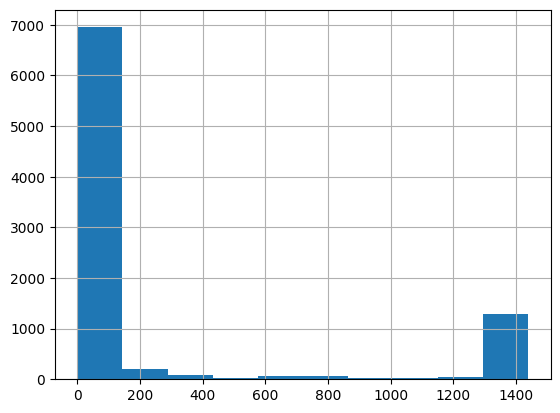

In [247]:
df.delay.hist()

# Delay Minimization

In [248]:
df.head()

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff,source,commercial,url,delay
0,2023-12-19 00:00:00,2023-12-19 00:00:00,HV 5752 Transavia,Amsterdam,BAGGAGE HANDLED,Marrakech (RAK),326,0.0,19DEC2023_AMS_processed.csv,NaN,NaN,0.0
1,2023-12-19 00:10:00,2023-12-19 00:10:00,HV 6888 Transavia,Amsterdam,BAGGAGE HANDLED,Reykjavik (KEF),262,0.0,19DEC2023_AMS_processed.csv,NaN,NaN,0.0
2,2023-12-19 00:15:00,2023-12-19 00:15:00,HV 6110 Transavia,Amsterdam,BAGGAGE HANDLED,Malaga (AGP),233,0.0,19DEC2023_AMS_processed.csv,NaN,NaN,0.0
3,2023-12-19 00:20:00,2023-12-19 00:44:00,OR 3721 TUI fly,Amsterdam,BAGGAGE HANDLED,Sao Vicente Island (VXE),227,1440.0,19DEC2023_AMS_processed.csv,NaN,NaN,24.0
4,2023-12-19 00:25:00,2023-12-19 00:25:00,HV 5662 Transavia,Amsterdam,BAGGAGE HANDLED,Las Palmas de Gran Canaria (LPA),310,0.0,19DEC2023_AMS_processed.csv,NaN,NaN,0.0


In [249]:
G = nx.DiGraph()

for index, row in df.iterrows():
    G.add_edge(
        row['orig'], 
        row['dest'], 
        departure_time=row['time_sch'],
        delay=row['delay'],
    )

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(658, 1174)

In [250]:
# custom function to optimize the network
def optimize_flight_route(graph):
    # finding optimal paths. The weight can be any variable in the dataset!
    path_weights = nx.all_pairs_bellman_ford_path_length(graph, weight='delay')
    
    final_sorted_paths = {}
    for source, weights in path_weights:
        # filter out the self-path (going back to the origin) and paths with non-positive weights
        filtered_weights = {node: weight for node, weight in weights.items() if node != source and weight >= 0}
        
        # if not filtered_weights: final_sorted_paths[source] = []
        if not filtered_weights: continue # skip empty paths
            
        # sort the paths as desired
        sorted_paths = sorted(filtered_weights.items(), key=lambda x: x[1], reverse=False)
        final_sorted_paths[source] = sorted_paths
        
    return final_sorted_paths

# run the optimization algorithm
optimized_paths = optimize_flight_route(G)

In [251]:
len(optimized_paths.keys()) # origins!

558

In [252]:
df.orig.value_counts()

orig
HKG                    1955
Amsterdam              1829
London                  637
Taipei                  153
Seoul/ICN                95
                       ... 
Malaga                    1
Tunis                     1
ALA                       1
Seoul                     1
Singapore\r\nPenang       1
Name: count, Length: 560, dtype: int64

In [253]:
df[df.orig.apply(lambda x: "London" in x)].orig.value_counts()

orig
London                                   637
London Heathrow (LHR)                     53
London City (LCY)                         40
London Gatwick (LGW)                      28
London/LHR                                26
London Luton (LTN)                        19
London Stansted (STN)                      5
Philadelphia\r\nCologne\r\nLondon/STN      3
London Southend (SEN)                      2
Name: count, dtype: int64

[Chapter 50: Scheduling Problems in the Airline Industry](https://sites.rutgers.edu/jian-yang/wp-content/uploads/sites/191/2019/06/chapter50.pdf)

From section 5 Disruption Management for Airline Scheduling:

The most complete model considers flight delays, cancellations, peculiar deviations, aircraft ferrying, fleet substitution, and hub closures. Due to data availability and simplicity, let's focus on offering alternatives based on flight delays.

The ability of disruption management systems to provide multiple solutions is highly valued, specially because some issues arising in real time cannot be addressed by the underlying models without human intervention. Thus, having a diverse range of options for the decision maker should provide a better chance to find one that addresses the problem. 

In [254]:
origin = "London" # London Heathrow (LHR)

In [255]:
optimized_paths.get(origin)[:20] # potential rerouting options (not rescheduling!)

[('Singapore', 1.0),
 ('Johannesburg', 5.0),
 ('HKG', 5.0),
 ('Beijing/PEK', 5.0),
 ('Tokyo/NRT\r\nCincinnati', 5.0),
 ('Zurich', 5.0),
 ('Anchorage\r\nChicago\r\nLuxembourg', 5.0),
 ('Dublin', 6.0),
 ('London/LHR', 6.0),
 ('Dhaka', 6.0),
 ('Tianjin', 6.0),
 ('Manchester', 7.0),
 ('Abu Dhabi', 7.0),
 ('Kagoshima', 7.0),
 ('Tokyo/HND', 7.0),
 ('Quanzhou', 7.0),
 ('Haikou', 7.0),
 ('Milan/MXP', 7.0),
 ('B S Begawan', 7.0),
 ('Anchorage\r\nFelipe Angeles\r\nLuxembourg', 7.0)]

In [256]:
filter_condition = ( (df.orig == origin) & (df.delay >= 0) ) # include no delay?
df[filter_condition].sort_values("delay").head(20) ### not the same as optimized routes!

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff,source,commercial,url,delay
3351,2023-12-19 22:05:00,2024-01-01 22:06:00,SQ321,Singapore,NaN,London,251,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-2...,1.0
3104,2023-12-19 18:20:00,2024-01-01 18:24:00,BA824,Dublin,NaN,London,302,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-5...,4.0
3367,2023-12-19 22:25:00,2024-01-01 22:30:00,VS449,Johannesburg,NaN,London,276,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-3...,5.0
3004,2023-12-19 17:05:00,2024-01-01 17:10:00,AA107,New York City,NaN,London,269,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-3...,5.0
3285,2023-12-19 20:45:00,2024-01-01 20:51:00,EI179,Dublin,NaN,London,319,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-2...,6.0
2252,2023-12-19 07:50:00,2024-01-01 07:56:00,EI151,Dublin,NaN,London,240,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-2...,6.0
2142,2023-12-19 06:30:00,2024-01-01 06:36:00,BA388,Brussels,NaN,London,352,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-5...,6.0
2166,2023-12-19 06:45:00,2024-01-01 06:52:00,BA1304,Aberdeen,NaN,London,287,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-5...,7.0
3015,2023-12-19 17:10:00,2024-01-01 17:17:00,LX325,Zurich,NaN,London,245,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-2...,7.0
2254,2023-12-19 07:55:00,2024-01-01 08:02:00,BA366,Marseille,NaN,London,225,NaN,19DEC2023_LHR_processed.csv,NaN,https://www.heathrow.com/departures/terminal-3...,7.0
